In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_dir = Path('/content/drive/MyDrive/pokemons/pokemons')
pokemon_classes = [d.name for d in data_dir.iterdir() if d.is_dir()]
# Проверим количество папок с покемонами
print(pokemon_classes)
print(len(pokemon_classes))

['Greninja', 'Gossifleur', 'Steenee', 'Donphan', 'Ledian', 'Granbull', 'Zeraora', 'Litleo', 'Plusle', 'Toxel', 'Yamper', 'Infernape', 'Yanma', 'Tirtouga', 'Horsea', 'Basculin', 'Pikachu', 'Morpeko', 'Galvantula', 'Lillipup', 'Poipole', 'Pansage', 'Quilava', 'Alakazam', 'Pawniard', 'Cyndaquil', 'Politoed', 'Mr. Mime', 'Exeggutor', 'Butterfree', 'Kricketune', 'Milcery', 'Tapu Fini', 'Regidrago', 'Umbreon', 'Avalugg', 'Chespin', 'Turtonator', 'Azurill', 'Clobbopus', 'Klefki', 'Wormadam', 'Metang', 'Magnemite', 'Swinub', 'Azelf', 'Nosepass', 'Dratini', 'Pinsir', 'Yungoos', 'Tyrantrum', 'Cutiefly', 'Wobbuffet', 'Cherubi', 'Rayquaza', 'Porygon', 'Mienshao', 'Kangaskhan', 'Persian', 'Stufful', 'Spritzee', 'Slowpoke', 'Solrock', 'Shiftry', 'Sunflora', 'Kakuna', 'Kricketot', 'Arbok', 'Ariados', 'Machop', 'Shellder', 'Pangoro', 'Tepig', 'Riolu', 'Cubchoo', 'Mareanie', 'Hawlucha', 'Relicanth', 'Yamask', 'Mantyke', 'Happiny', 'Lumineon', 'Mienfoo', 'Centiskorch', 'Spheal', 'Breloom', 'Giratina', '

In [3]:
# Базовый класс для обработки датасета, размеры всех изображений возьмём 128*128
class PokemonDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.resize = transforms.Resize((128, 128))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = transforms.ToTensor()(img)
        img = self.resize(img)
        return img, label

In [4]:
# Даталоадер
full_dataset = datasets.ImageFolder(
    root=str(data_dir),
    transform=None
)

dataset = PokemonDataset(full_dataset)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)

In [5]:
# Архитектура нейронной сети
class PokemonNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 6, 3),
            nn.BatchNorm2d(num_features=6),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),

            nn.Conv2d(6, 16, 3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(14400, 1024),
            nn.ReLU(),
            nn.Linear(1024, 898)
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
# Параметры для обучения
device = "cpu"
writer = SummaryWriter('logs')
model = PokemonNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 20

# Обучение
for epoch in range(epochs):

    model.train()
    sum_epoch_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        sum_epoch_loss += loss.item()
    # Средний лосс по эпохе
    avg_epoch_loss = sum_epoch_loss / len(train_loader)

    # Валидация
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # Можно добавить и другие метрики
    accuracy = accuracy_score(all_labels, all_preds)

    print(f'\nEpoch {epoch+1}, Avg train Loss: {avg_epoch_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print('-' * 50)

    # Логирование лосса и точности
    writer.add_scalar('Loss/train_epoch', avg_epoch_loss, epoch)
    writer.add_scalar('Accuracy/val', accuracy, epoch)

writer.close()
# Сохранение
torch.save(model.state_dict(), 'pokemons_classifier')


Epoch 1, Avg train Loss: 7.0798
Accuracy: 0.0040
--------------------------------------------------

Epoch 2, Avg train Loss: 6.6060
Accuracy: 0.0060
--------------------------------------------------

Epoch 3, Avg train Loss: 6.1519
Accuracy: 0.0100
--------------------------------------------------

Epoch 4, Avg train Loss: 5.6097
Accuracy: 0.0140
--------------------------------------------------

Epoch 5, Avg train Loss: 5.0187
Accuracy: 0.0180
--------------------------------------------------

Epoch 6, Avg train Loss: 4.4336
Accuracy: 0.0359
--------------------------------------------------

Epoch 7, Avg train Loss: 3.8964
Accuracy: 0.0240
--------------------------------------------------

Epoch 8, Avg train Loss: 3.2566
Accuracy: 0.0419
--------------------------------------------------

Epoch 9, Avg train Loss: 2.6866
Accuracy: 0.0559
--------------------------------------------------

Epoch 10, Avg train Loss: 2.1192
Accuracy: 0.0539
----------------------------------------

In [7]:
# Загрузка
model = PokemonNet().to(device)
model.load_state_dict(torch.load("pokemons_classifier", weights_only=True))
model.eval()

PokemonNet(
  (layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=14400, out_features=1024, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1024, out_features=898, bias=True)
  )
)

In [10]:
full_dataset.classes

['Abomasnow',
 'Abra',
 'Absol',
 'Accelgor',
 'Aegislash',
 'Aerodactyl',
 'Aggron',
 'Aipom',
 'Alakazam',
 'Alcremie',
 'Alomomola',
 'Altaria',
 'Amaura',
 'Ambipom',
 'Amoonguss',
 'Ampharos',
 'Anorith',
 'Appletun',
 'Applin',
 'Araquanid',
 'Arbok',
 'Arcanine',
 'Arceus',
 'Archen',
 'Archeops',
 'Arctovish',
 'Arctozolt',
 'Ariados',
 'Armaldo',
 'Aromatisse',
 'Aron',
 'Arrokuda',
 'Articuno',
 'Audino',
 'Aurorus',
 'Avalugg',
 'Axew',
 'Azelf',
 'Azumarill',
 'Azurill',
 'Bagon',
 'Baltoy',
 'Banette',
 'Barbaracle',
 'Barboach',
 'Barraskewda',
 'Basculin',
 'Bastiodon',
 'Bayleef',
 'Beartic',
 'Beautifly',
 'Beedrill',
 'Beheeyem',
 'Beldum',
 'Bellossom',
 'Bellsprout',
 'Bergmite',
 'Bewear',
 'Bibarel',
 'Bidoof',
 'Binacle',
 'Bisharp',
 'Blacephalon',
 'Blastoise',
 'Blaziken',
 'Blipbug',
 'Blissey',
 'Blitzle',
 'Boldore',
 'Boltund',
 'Bonsly',
 'Bouffalant',
 'Bounsweet',
 'Braixen',
 'Braviary',
 'Breloom',
 'Brionne',
 'Bronzong',
 'Bronzor',
 'Bruxish',
 'Bu

Тест 1:
Истинный класс: Paras
1 место: Krabby (90.87%)
2 место: Rapidash (7.40%)
3 место: Fearow (0.59%)


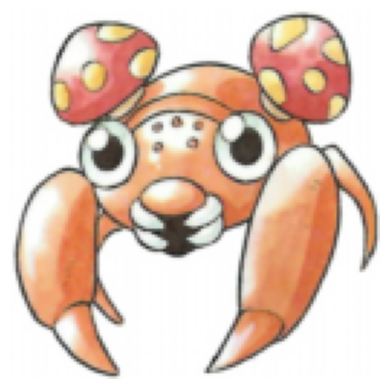

Тест 2:
Истинный класс: Xatu
1 место: Fraxure (27.22%)
2 место: Stunfisk (26.37%)
3 место: Toxtricity (23.62%)


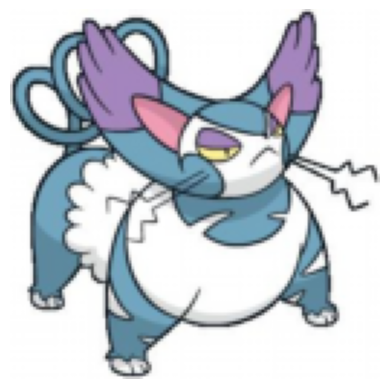

Тест 3:
Истинный класс: Manectric
1 место: Manectric (70.62%)
2 место: Pidgeot (25.56%)
3 место: Treecko (1.52%)


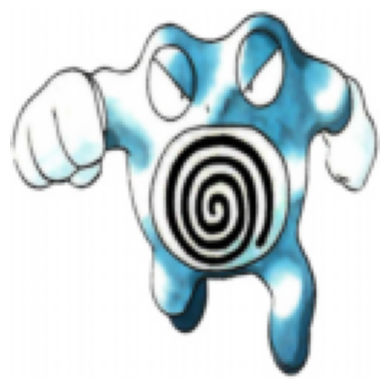

Тест 4:
Истинный класс: Vivillon
1 место: Sliggoo (61.06%)
2 место: Swirlix (27.26%)
3 место: Jellicent (6.69%)


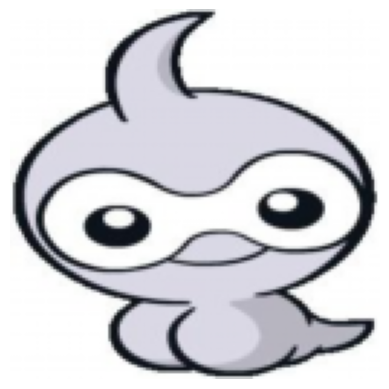

Тест 5:
Истинный класс: Hitmonlee
1 место: Raikou (99.47%)
2 место: Yanma (0.35%)
3 место: Mr. Mime (0.08%)


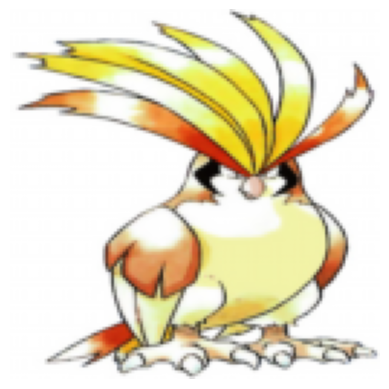

In [12]:
# Проверка модели
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        if batch_idx == 5:
            break
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        pred_probs, preds = torch.topk(probabilities, 3)

        class_names = full_dataset.classes

        print(f"Тест {batch_idx+1}:")
        print(f"Истинный класс: {class_names[labels[batch_idx].item()]}")
        for i in range(3):
            print(f"{i+1} место: {class_names[preds[batch_idx][i].item()]} ({pred_probs[batch_idx][i].item():.2%})")

        img = images[0].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(np.clip(img, 0, 1))
        plt.axis('off')
        plt.show()

К данному решению можно было бы добавить аугментацию изображений, улучшить слои внутри сети, подобрать гиперпараметры при обучении, но решение всё равно будет достаточно слабое (например, из-за того, что изображений одного класса очень мало).
Метрики указаны при обучении, в целом получилось базовое решение задачи классификации покемонов.